## Load Data

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [3]:
df = pd.read_csv('../dataset/after_selection/train.csv')
df.head()

,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Age_Bin,Vehicle_Damage_Age_Interaction,Response
0,1,46.0,1,0,0,152.0,0,0,0
1,1,46.0,1,0,0,152.0,0,0,0
2,1,46.0,1,1,1,26.0,2,2,0
3,1,18.0,1,0,0,152.0,1,0,0
4,1,11.0,0,1,1,122.0,2,2,0


## 1. Modeling

### Split Data Train & Test

In [4]:
X = df.drop(columns=['Response'])
y = df[['Response']]

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Algoritma Modeling

#### Test All Classifier

In [ ]:
# # Define a list of classifiers to try
# classifiers = [
#     LogisticRegression(),
#     KNeighborsClassifier(),
#     SVC(),
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
#     GaussianNB(),
#     GradientBoostingClassifier(),
#     AdaBoostClassifier(),
#     XGBClassifier(),
#     CatBoostClassifier(),
# ]

# # Create an empty DataFrame to store results
# results_df = pd.DataFrame(columns=['Classifier', 'Accuracy'])

# # Train and evaluate each classifier
# for classifier in classifiers:
#     try:
#         # Train the classifier
#         classifier.fit(X_train, y_train)

#         # Make predictions on the test set
#         y_pred = classifier.predict(X_test)

#         # Evaluate the model performance
#         accuracy = accuracy_score(y_test, y_pred)

#         # Append results to the DataFrame
#         results_df = results_df.append({'Classifier': classifier.__class__.__name__, 'Accuracy': accuracy}, ignore_index=True)

#     except Exception as e:
#         # Handle exceptions
#         print(f"Error with {classifier.__class__.__name__}: {e}")

# results_df.to_csv('../dataset/results/classifier_accuracy.csv', index=False)

In [7]:
results_df = pd.read_csv('../dataset/results/classifier_accuracy.csv')
results_df.sort_values(by='Accuracy', ascending=False)

,Classifier,Accuracy
9,CatBoostClassifier,0.797309
8,XGBClassifier,0.797088
7,AdaBoostClassifier,0.795538
6,GradientBoostingClassifier,0.792493
4,RandomForestClassifier,0.792216
3,DecisionTreeClassifier,0.789946
5,GaussianNB,0.784022
0,LogisticRegression,0.783081
2,SVC,0.774167
1,KNeighborsClassifier,0.767135


#### Evaluation Method

In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold


def eval_classification(model, X_train, X_test, y_train, y_test, n_splits=5):
    # Evaluate on the test set
    y_pred_test = model.predict(X_test)

    # StratifiedKFold for cross-validation with stratified sampling
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_test_results = cross_validate(model, X_test, y_test, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)
    cv_train_results = cross_validate(model, X_train, y_train, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)
    

    # Display metrics for the training set
    print("Metrics for the Test Set:")
    print("Accuracy: %.2f" % accuracy_score(y_test, y_pred_test))
    print("Precision: %.2f" % precision_score(y_test, y_pred_test))
    print("Recall: %.2f" % recall_score(y_test, y_pred_test))
    print("F1-Score: %.2f" % f1_score(y_test, y_pred_test))
    print()

    # Display cross-validation results
    print("Metrics Using Cross Validation:")
    print(f"Mean ROC-AUC (Test): {cv_test_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Test): {cv_test_results['test_roc_auc'].std():.2f}")
    print()
    print(f"Mean ROC-AUC (Train): {cv_train_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Train): {cv_train_results['test_roc_auc'].std():.2f}")

#### XGBoost

In [78]:
base_model = XGBClassifier()
base_model.fit(X_train, y_train)

In [83]:
eval_classification(base_model, X_train, X_test, y_train, y_test)

Metrics for the Test Set:
Accuracy: 0.80
Precision: 0.73
Recall: 0.93
F1-Score: 0.82

Metrics Using Cross Validation:
Mean ROC-AUC (Test): 0.83
Std ROC-AUC (Test): 0.01

Mean ROC-AUC (Train): 0.85
Std ROC-AUC (Train): 0.00


### Hyperparameter Tunning

In [88]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

In [84]:
xgb_model = XGBClassifier()

In [85]:
# Define the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [89]:
# Create GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}


In [90]:
# Get the best model from grid search
best_xgb_model = grid_search.best_estimator_

### Best Result

In [91]:
eval_classification(best_xgb_model, X_train, X_test, y_train, y_test)

Metrics for the Test Set:
Accuracy: 0.80
Precision: 0.73
Recall: 0.94


F1-Score: 0.82

Metrics Using Cross Validation:
Mean ROC-AUC (Test): 0.84
Std ROC-AUC (Test): 0.01

Mean ROC-AUC (Train): 0.85
Std ROC-AUC (Train): 0.00


In [92]:
filename = './models/xgboost_model.sav'
pickle.dump(best_xgb_model, open(filename, 'wb'))

## Feature Importance

                          Feature  Importance
1                     Region_Code    0.002015
3                     Vehicle_Age    0.003744
5            Policy_Sales_Channel    0.004191
0                 Driving_License    0.004207
7  Vehicle_Damage_Age_Interaction    0.019673
6                         Age_Bin    0.022333
2              Previously_Insured    0.378895
4                  Vehicle_Damage    0.564942


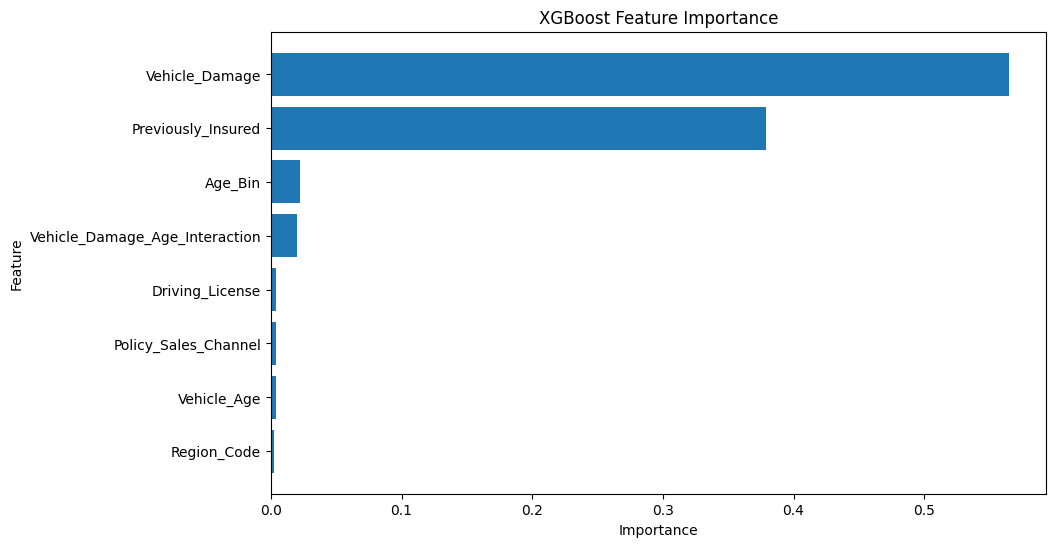

In [93]:
# Get feature importances
feature_importances = best_xgb_model.feature_importances_

# Get feature names (optional)
feature_names = [f'Feature {i}' for i in range(X.shape[1])]

# Create a DataFrame for better visualization (optional)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Print or plot the feature importance
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()